In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np


Distiller Class

In [ ]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)

            # Compute scaled distillation loss from https://arxiv.org/abs/1503.02531
            # The magnitudes of the gradients produced by the soft targets scale
            # as 1/T^2, multiply them by T^2 when using both hard and soft targets.
            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

Creating Teacher and Student Model

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen_with_aug = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = train_datagen_with_aug.flow_from_directory(
    r'/content/drive/My Drive/DRIMG',
    target_size=(224, 224),
    batch_size=32,
    # color_mode='grayscale',
    class_mode='sparse',
    subset='training'
    ) # set as training data

validation_generator = train_datagen_with_aug.flow_from_directory(
    r'/content/drive/My Drive/DRIMG', # same directory as training data
    target_size=(224, 224),
    batch_size=32,
    # color_mode='grayscale',
    class_mode='sparse',
    subset='validation'
    ) # set as validation data

#input_img = Input(shape=(224, 224, 3))

Found 2248 images belonging to 5 classes.
Found 562 images belonging to 5 classes.


In [ ]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D, AveragePooling2D
# from keras.layers.merge import concatenate

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten, Dense
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np

In [ ]:
# Create the teacher
from tensorflow.keras.models import load_model
teacher = load_model('/content/drive/MyDrive/RESNET_152(ADAM_0.01).h5')
#teacher = (("/content/drive/MyDrive/RESNET_152(ADAM_0.01).h5"),
   # [
      #  keras.Input(shape=(28, 28, 1)),
       # layers.Conv2D(256, (3, 3), strides=(2, 2), padding="same"),
       # layers.LeakyReLU(alpha=0.2),
      #  layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
       # layers.Conv2D(512, (3, 3), strides=(2, 2), padding="same"),
      #  layers.Flatten(),
       # layers.Dense(10),
   #() ],
    #name="teacher"


from tensorflow.keras.applications import Xception
xception_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

xception_model.summary()
# Create a Sequential model
xception = keras.models.Sequential()

# Set layers in densenet169_model to non-trainable
for layer in xception_model.layers:
    layer.trainable = False


# Add layers to the model
xception.add(xception_model)
xception.add(Flatten())
xception.add(Dropout(0.2))
xception.add(Dense(1024,activation='relu'))
xception.add(Dropout(0.2))
xception.add(Dense(512, activation='relu'))
xception.add(Dense(5, activation='softmax'))

xception.summary()

teacher= xception

# Create the student
student = keras.Sequential(
    [
        keras.Input(shape=(224, 224, 3)),

        layers.Conv2D(16, (5, 5), strides=(2, 2), padding="same"),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

        layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),


        layers.Conv2D(48, (3, 3), strides=(2, 2), padding="same"),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),


        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

        layers.Conv2D(128, (3, 3), strides=(1, 1), padding="same"),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

        layers.Flatten(),
        layers.Dense(600),
        layers.Dense(300),
        layers.Dense(150),
        layers.Dense(5),


    ],
    name="student",
)
student.summary()

# Clone student for later comparison
student_scratch = keras.models.clone_model(student)


Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_4[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]

Train the Teacher Network and Distill the Teacher weights to Student

In [ ]:
 #Initialize and compile distiller
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=6,
)

# Distill teacher to student
graph=distiller.fit(train_generator, epochs=25, validation_data = validation_generator)
graph

# Evaluate student on test dataset
#distiller.evaluate(train_generator, epochs=15, validation_data = validation_generator)

Epoch 1/25
71/71 [==============================] - 624s 9s/step - sparse_categorical_accuracy: 0.4942 - student_loss: 1.5318 - distillation_loss: 0.0054 - val_sparse_categorical_accuracy: 0.6388 - val_student_loss: 1.5078
Epoch 2/25
71/71 [==============================] - 483s 7s/step - sparse_categorical_accuracy: 0.6259 - student_loss: 1.4779 - distillation_loss: 0.0078 - val_sparse_categorical_accuracy: 0.6263 - val_student_loss: 1.4973
Epoch 3/25
71/71 [==============================] - 494s 7s/step - sparse_categorical_accuracy: 0.6370 - student_loss: 1.4702 - distillation_loss: 0.0083 - val_sparse_categorical_accuracy: 0.6299 - val_student_loss: 1.5529
Epoch 4/25
71/71 [==============================] - 483s 7s/step - sparse_categorical_accuracy: 0.6361 - student_loss: 1.4620 - distillation_loss: 0.0085 - val_sparse_categorical_accuracy: 0.6601 - val_student_loss: 1.4212
Epoch 5/25
71/71 [==============================] - 486s 7s/step - sparse_categorical_accuracy: 0.6428 - stu

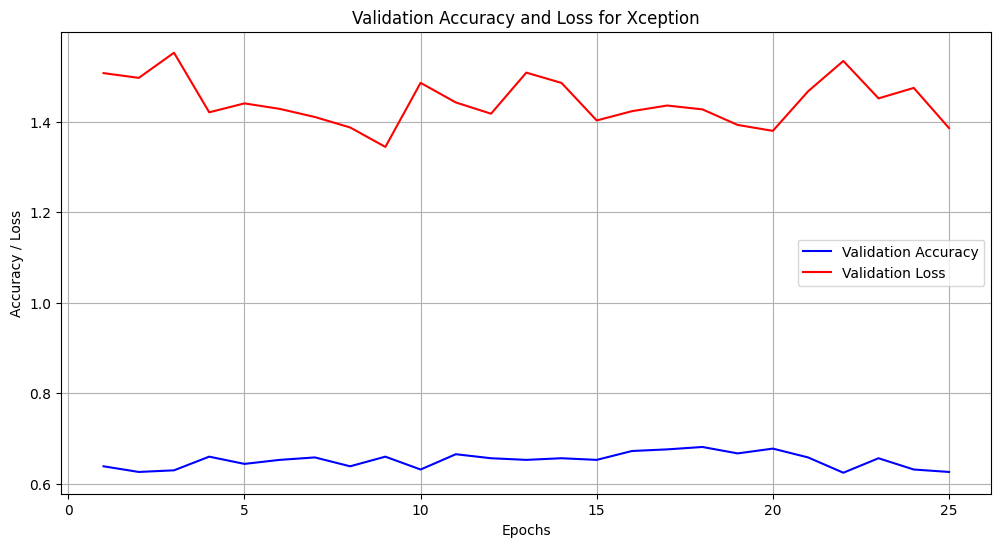

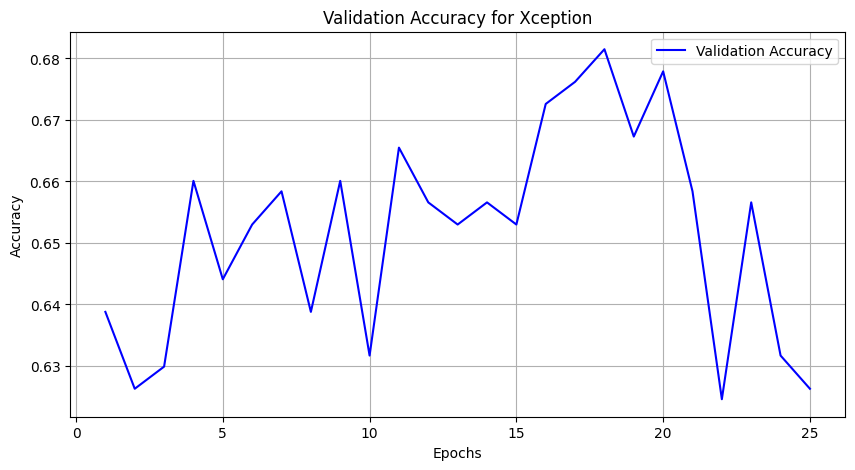

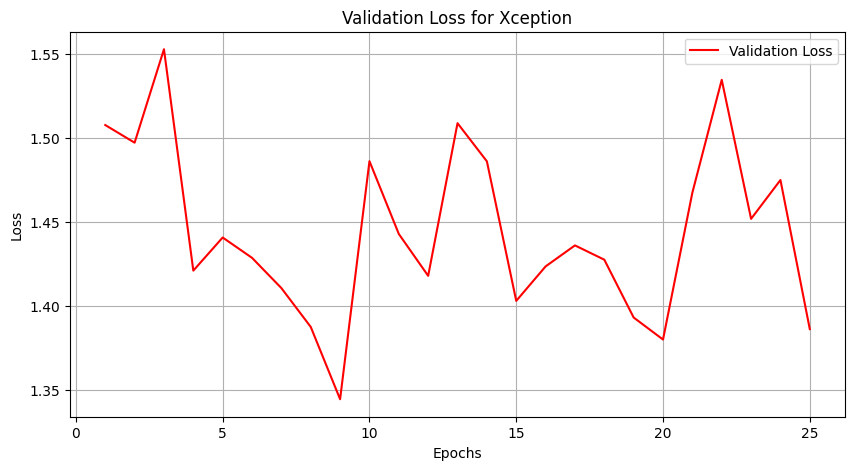

In [2]:
import matplotlib.pyplot as plt

# Data for validation accuracy and validation loss
val_accuracy = [0.6388, 0.6263, 0.6299, 0.6601, 0.6441, 0.6530, 0.6584, 0.6388, 0.6601, 0.6317,
                0.6655, 0.6566, 0.6530, 0.6566, 0.6530, 0.6726, 0.6762, 0.6815, 0.6673, 0.6779,
                0.6584, 0.6246, 0.6566, 0.6317, 0.6263]

val_loss = [1.5078, 1.4973, 1.5529, 1.4212, 1.4409, 1.4288, 1.4108, 1.3877, 1.3447, 1.4863,
            1.4430, 1.4181, 1.5089, 1.4862, 1.4032, 1.4237, 1.4362, 1.4277, 1.3933, 1.3802,
            1.4676, 1.5347, 1.4520, 1.4751, 1.3864]

epochs = range(1, 26)

# Combined Plot for Validation Accuracy and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Validation Accuracy and Loss for Xception')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.legend()
plt.grid(True)
plt.show()

# Separate Plot for Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Validation Accuracy for Xception')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Separate Plot for Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Validation Loss for Xception')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

fig1 = plt.gcf()

plt.plot(graph.history['sparse_categorical_accuracy'])
plt.plot(graph.history['val_sparse_categorical_accuracy'])

# plt.axis(ymin=0.4, ymax=1)
plt.grid()

plt.title('OSPS-MicroNet model Accuracy to its teacher ResNet152')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','validation'])

plt.show()

NameError: ignored

<Figure size 640x480 with 0 Axes>

In [ ]:
max_acc = max(graph.history['val_sparse_categorical_accuracy'])
print('The highest accuracy achieved for OSPS-MicroNet model Accuracy to its teacher ResNet152 model is',max_acc*100)

NameError: ignored